[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/center4ml/Workshops/blob/2022_2/Day2/day2_1_autoencoders.ipynb)

# Autoencoders

Type of neural network which typically aims to learn efficient representations (efficient coding) of the data.
Usually autoencoders are trained in an unsupervised manner.


### Applications
1. Anomaly detection
2. Pretraining
3. Dimensionality reduction
4. Denoising

**Reconstruction**
![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

### Some more examples of autoencoders:
- [convolutional](https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac)
- [time series data](https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [tabular data](https://medium.com/@vkansal/credit-card-fraud-detection-using-deep-learning-pytorch-47f680a8c5be) [(code)](https://github.com/vimalkansal/credit_card_fraud_detection/blob/master/project/credit_card_fraud_detection.ipynb)
- [a lot of VAE](https://github.com/AntixK/PyTorch-VAE)

# Recapitulation

Import base libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Import PyTorch libraries

In [ ]:
import torch
import torchvision

In [ ]:
DATASETS_PATH = 'data' # path to directory where data are to be stored

In [ ]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

In [ ]:
mnist_train = torchvision.datasets.MNIST(root=DATASETS_PATH, train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root=DATASETS_PATH, train=False, download=True, transform=transform);

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



<class 'torch.Tensor'> torch.Size([1, 28, 28])


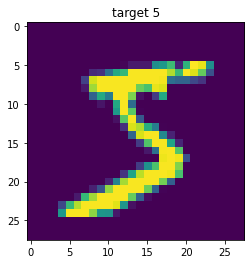

In [ ]:
train_image, train_target = mnist_train[0]    #let us examine the first sample (index 0)
print(type(train_image), train_image.shape)
plt.imshow(train_image[0])
plt.title(f'target {train_target}');

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self): # initialize model, called at model = MLP(). In genereal you can pass arguments to initializer, e.g. number or size of hidden layers (not in this example)
        super().__init__() # must inherit from torch.nn.Module (backpropagation etc.)
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way, 
                                          #that output from a preceding layer serves as input to the next layer 
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.Sigmoid(),
            # torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            # torch.nn.Sigmoid(),
            torch.nn.Linear(1024, 256),
            torch.nn.Sigmoid(),            #Sigmoid is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
    def forward(self, x): # run model, called at out = model(x)
        out = self.mlp(x)
        return out

In [ ]:
batch_size = 256
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
net = MLP()
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001. We will be using ADAM optimizer throughout the workshop
                                                        #different choices are possible, but this is outside the scope of this workshop

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(2):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(mnist_train_dataloader):
        batch_inputs, batch_labels = data
        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)
        
        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear 
                                            #and MLP doesn't apply 
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        if (batch+1) % 50 == 0:
            print("epoch:", epoch, "batch:", batch+1, "current batch loss:", loss.item()) 
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network. 
                                ####You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update

epoch: 0 batch: 50 current batch loss: 0.7071917653083801
epoch: 0 batch: 100 current batch loss: 0.3226902186870575
epoch: 0 batch: 150 current batch loss: 0.2799924910068512
epoch: 0 batch: 200 current batch loss: 0.27158206701278687
epoch: 1 batch: 50 current batch loss: 0.2605012357234955
epoch: 1 batch: 100 current batch loss: 0.15305742621421814
epoch: 1 batch: 150 current batch loss: 0.18755905330181122
epoch: 1 batch: 200 current batch loss: 0.13314317166805267


# GPU computing

In [ ]:
t =torch.tensor([1.3, 4.5])
print(t)
print(t.device)

tensor([1.3000, 4.5000])
cpu


check if CUDA (GPU) is available

In [ ]:
torch.cuda.is_available()

True

If you get `False`, in Colab panel do the following: Runtime -> Change runtime type
Set "Hardware accelerator" to "GPU", click "Save"

You get new runtime, all variables and imports are cleared - please run cells above (without time consuming training)


In [ ]:
torch.cuda.is_available()

True

You can set device for computation for tensors and torch modules (e.g. models)

In [ ]:
t =torch.tensor([1.3, 4.5])
print(t.dtype, t.device)
t_cuda = t.to('cuda'); #equivalent to t.cuda()
print(t.dtype, t.device, 'Tensor still on cpu')
print(t_cuda.dtype, t_cuda.device, 'Tensor on gpu')

torch.float32 cpu
torch.float32 cpu Tensor still on cpu
torch.float32 cuda:0 Tensor on gpu


You can only do mathematical operation on tensors stored on the same device

In [ ]:
print(torch.tensor([1.3, 4.5]) * torch.tensor([3.]))
print(torch.tensor([1.3, 4.5]).to('cuda') * torch.tensor([3.]).to('cuda'))

tensor([ 3.9000, 13.5000])
tensor([ 3.9000, 13.5000], device='cuda:0')


In [ ]:
print(torch.tensor([1.3, 4.5]).to('cuda') * torch.tensor([3.]))

RuntimeError: ignored

Let's create sample model and input for the model

In [ ]:
model = MLP()
model_input = torch.rand(1,1,28,28)

By dafault, all instances are created for cpu calculations

In [ ]:
out = model(model_input)

Model (torch.nn.Module) can be transferred to gpu in this way:
(note, that Modules are transferred "in place", while tensors are copied)

In [ ]:
model.to('cuda')

MLP(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)

Now it will work with 'gpu' input, but fail for 'cpu'

In [ ]:
out = model(model_input)

RuntimeError: ignored

In [ ]:
out = model(model_input.to('cuda'))

The output is also located on gpu

In [ ]:
print(out.device)

cuda:0


Caution! PyTorch Modules (e.g. models) do not have 'device' attribute (you will get `AttributeError`)

In [ ]:
model.device

AttributeError: ignored

In practice, we usually keep the device (CPU or GPU) as a variable, and apply it to modules and data:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda


In [ ]:
model.to(device);

In [ ]:
model_input = torch.rand(1,1,28,28)
print('`model_input` device:', model_input.device)

`model_input` device: cpu


In [ ]:
model_output = model(model_input.to(device))
print('output data is on device:', model_output.device)

output data is on device: cuda:0


Before converting to numpy array, tensors must be transferred to CPU and detached from computational graph. That all takes a long command `.detach().cpu().numpy()`:

In [ ]:
model_output_numpy = model_output.detach().cpu().numpy()
print(type(model_output_numpy))
print(model_output_numpy)

<class 'numpy.ndarray'>
[[-0.05009422 -0.15442261  0.22541091  0.3181879   0.01090802 -0.29697174
   0.27436942 -0.32194787  0.4088781   0.1437266 ]]


# Autoencoders

## Data

First, let's have a look on the data. They are MNIST dataset - the same as last week.

This time images are not normalized

In [ ]:
from torchvision.datasets import MNIST
from torchvision import  transforms

In [ ]:
transform = transforms.ToTensor()

In [ ]:
mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=transform);
mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=transform);

Let's see what the data look like

In [ ]:
img, target = mnist_train[0]
print(f'image type: {type(img)}, image shape: {img.shape}, target: {target}, target class name: {mnist_train.classes[target]}')

image type: <class 'torch.Tensor'>, image shape: torch.Size([1, 28, 28]), target: 5, target class name: 5 - five


The image is a torch.Tensor object, and the target an integer. Notice that the image has 3 dimensions: single channel and 28 height x 28 width \
In order to visualize it correctly, we need to reduce it to 2 dimensional  height x width tensor

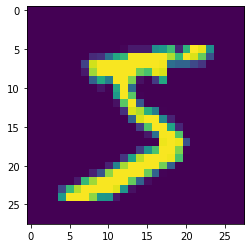

In [ ]:
plt.imshow(img[0])

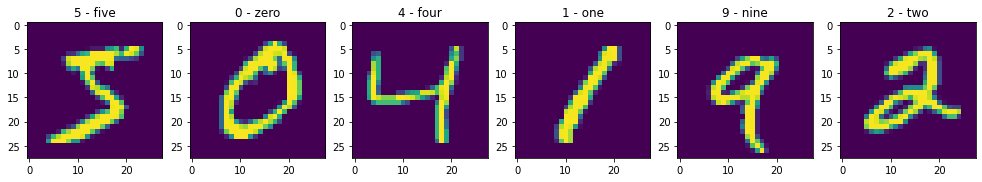

In [ ]:
num_images = 6
fig, axs = plt.subplots(ncols=num_images, figsize=(17,5))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[i].imshow(img[0])
    axs[i].set_title(f'{mnist_train.classes[target]}')
    
    

## Model

In [ ]:
import torch
from torch import nn

### Encoder

#### Task 1.1: write encoder class with a single hidden layer

Let's start with fully-connected model, i. e. perceptron.
1. As the input, model should take batch of 1d vectors with of 28x28 length (number of pixels)
2. Number of neurons in hidden layer should be an argument of constructor (`__init__` function)
3. The same applies to the number of latent space dimesions 

In [ ]:
class Encoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        #your code here
        ...

    def forward(self, x):
        #your code here
        out = ...
        return out

Try if it works:

In [ ]:
#prepare data
img, target = mnist_train[0]
img = img.reshape(-1)
print('image shape:', img.shape)

image shape: torch.Size([784])


In [ ]:
# prepare encoder
hidden_dim = 64
latent_dim = 12
encoder = Encoder_1hl(hidden_dim, latent_dim)

In [ ]:
# compute representation in latent space
batch = img.unsqueeze(0) #model operates on batched input. Let's create batch with one sample
print('batch shape:', batch.shape)
with torch.no_grad(): #turn off gradient for this calculation
    z = encoder(batch)
print('output shape:', z.shape)

batch shape: torch.Size([1, 784])
output shape: torch.Size([1, 12])


### Decoder

In [ ]:
class Decoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid() # sigmoid function transforms input values (-inf, +inf) to output in range (0, 1)
            )
            

    def forward(self, x):
        x = self.net(x)
        return x

### Autoencoder = Encoder + Decoder

Let's put it all together.

#### Task 1.2: write autoencoder class

Encoder and decoder should have 1 hidden layer each

In [ ]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        # your code here
        ...
            
    def forward(self, x):
        # your code here
        z = ... #embedding
        x_hat = ... # reconstruction
        return x_hat, z # we want to have both the reconstruction and the embedding

In [ ]:
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)

In [ ]:
batch = img.unsqueeze(0) #model operates on batched input. Let's create batch with one sample
print('batch shape:', batch.shape)
with torch.no_grad(): #turn off gradient
    x_hat, z = autoencoder(batch)
print('output shape:', x_hat.shape)
print('latent shape:', z.shape)

batch shape: torch.Size([1, 784])
output shape: torch.Size([1, 784])
latent shape: torch.Size([1, 12])


So far, the model operates on flatten images. Yet everywhere else we prefer to operate on 1x28x28 images. Let's modify the `forward` function to do the reshaping

#### Task 1.2a: add reshaping

In [ ]:
class Autoencoder_1hl(nn.Module):
    
    # paste your __init__ function here

    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.reshape(input_shape[0], -1) # usually: x.view(input_shape[0], -1) does the job as well
        
        # paste the rest of your forward function here
        
        return x.reshape(input_shape)


Try the new model

In [ ]:
img, target = mnist_train[0]
batch = img.unsqueeze(0) #model operates on batched input. Let's create batch with one sample
print('batch shape:', batch.shape)
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)
with torch.no_grad(): #turn off gradient
    x_hat, z = autoencoder(batch)
print('output shape:', x_hat.shape)

batch shape: torch.Size([1, 1, 28, 28])
output shape: torch.Size([1, 1, 28, 28])


#### Visualize

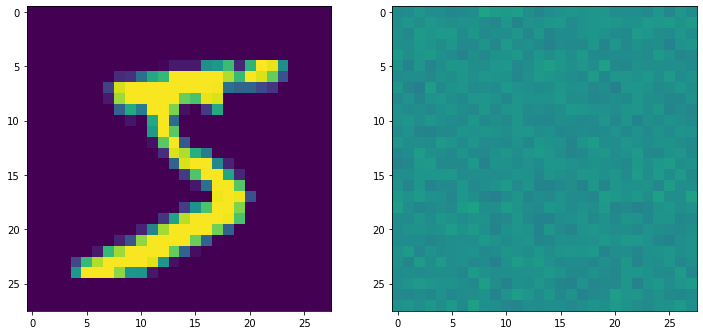

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.imshow(batch[0,0], vmin=0, vmax=1) # why [0,0]? first item from batch, first channel
ax2.imshow(x_hat[0,0], vmin=0, vmax=1)

## Training

Prepare dataloaders

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 128

In [ ]:
mnist_train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

Closer look on dataloaders

In [ ]:
x, y = next(iter(mnist_train_dataloader))
print(f'x shape: {x.shape}')
print(f'target shape: {y.shape}')
print(f'target: {y}')

x shape: torch.Size([128, 1, 28, 28])
target shape: torch.Size([128])
target: tensor([1, 3, 1, 4, 2, 4, 0, 9, 8, 2, 1, 4, 3, 7, 4, 5, 1, 3, 7, 1, 1, 6, 7, 7,
        0, 9, 6, 1, 3, 6, 6, 4, 5, 8, 7, 5, 5, 4, 1, 6, 5, 9, 5, 1, 5, 3, 7, 9,
        8, 8, 9, 4, 9, 1, 4, 3, 7, 2, 1, 2, 8, 4, 6, 2, 8, 9, 9, 8, 5, 3, 0, 9,
        3, 0, 5, 7, 4, 8, 0, 5, 4, 9, 5, 4, 7, 3, 3, 6, 6, 7, 4, 7, 7, 6, 7, 4,
        5, 9, 2, 8, 3, 1, 3, 7, 9, 9, 8, 6, 1, 1, 4, 7, 7, 4, 8, 8, 6, 9, 6, 5,
        9, 1, 7, 4, 1, 5, 1, 1])


### Schema of training in PyTorch

Set model, optimizer (which performs optimizing steps) and criterion
```
model = ...
optimizer =  torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = ... #function which computes loss
```

Set device on which computations will be done: 'cpu' or 'cuda' (GPU)
```
device = 'cuda' if torch.cuda.is_available() else 'cpu' # if your machine supports cuda, it wil be used for computation
```

set model to 'train' mode and allocate it to the device
```
model.train().to(device);
```

Schema for single epoch training:
```
for x, y in mnist_train_dataloader:    
    # clear gradient from previous step
    optimizer.zero_grad()
    
    x = x.to(device)
    ... = model(x) # run model
    ... # some processing, if needed 
    loss = ... # calculate batch loss

    # compute accumulated gradients
    loss.backward()

    # perform parameter update based on current gradients
    optimizer.step()
 ```

#### Task 2.1: training loop
write training loop for 2 epochs for autoencoder. Set criterion to mean square root error `nn.MSELoss()`

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # if your machine supports cuda, it wil be used for computation
print(f'device: {device}')
autoencoder.to(device).train();
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss() #the same as nn.functional.mse_loss

device: cuda


Check batches from dataloader

In [ ]:
x, y = next(iter(mnist_train_dataloader))
print(x.shape, y.shape)

# # equivalent to
# for x, y in mnist_train_dataloader:
#   break

torch.Size([128, 1, 28, 28]) torch.Size([128])


Check x_hat computation step

In [ ]:
x_hat, z = autoencoder(x.to(device))
print(x_hat.shape, z.shape)
print(x_hat.device)

torch.Size([128, 1, 28, 28]) torch.Size([128, 12])
cuda:0


Check loss computation

In [ ]:
loss = criterion(x.to(device), x_hat) # note, that x_hat is already at `device`

In [ ]:
loss

tensor(0.2324, device='cuda:0', grad_fn=<MseLossBackward0>)

Now, write the training loop:

In [ ]:
num_epochs = 2 #first let's do a short training, to see if the loss go down

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []

    # your code here

    epoch_loss = ...  # your code here
    
    print(f'epoch {i_epoch}, loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})

epoch 0, loss: 0.0571
epoch 1, loss: 0.0287


Having small loss on training is good, but we really want the model to generalize for unseen samples. Let's calculate loss on test dataset after each epoch

#### Task 2.2: evaluation function
Write function which calculates loss of the model on test dataset

In [ ]:
@torch.no_grad() #this decorator disable gradient computation in function. Equivalent to `with torch.no_grad():` inside function. Makes code clearer
def evaluate_model(model, dataloader, criterion):
    # your code here
    # ...
    # final_loss = ...
    return final_loss

Test if your function works

In [ ]:
test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion)
print(f'test loss: {test_loss:0.4f}')

test loss: 0.0283


Now we are ready to implement testset evaluation and do the proper traing of the model. For clarity, let's create a fresh autoencoder

In [ ]:
hidden_dim = 64
latent_dim = 12
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)
autoencoder.to(device).train();

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(x)
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion)
    autoencoder.train() # if "evaluate_model" switches the model to 'eval' mode, switch it back 'train'
    print(f'epoch {i_epoch+1}/{num_epochs}, train loss: {epoch_loss:0.4f}, test loss {test_loss:0.4f}')
    history.append({'train loss': epoch_loss, 'test loss': test_loss})
        

epoch 1/10, train loss: 0.0619, test loss 0.0403
epoch 2/10, train loss: 0.0350, test loss 0.0301
epoch 3/10, train loss: 0.0276, test loss 0.0252
epoch 4/10, train loss: 0.0244, test loss 0.0230
epoch 5/10, train loss: 0.0228, test loss 0.0218
epoch 6/10, train loss: 0.0219, test loss 0.0211
epoch 7/10, train loss: 0.0213, test loss 0.0206
epoch 8/10, train loss: 0.0208, test loss 0.0201
epoch 9/10, train loss: 0.0204, test loss 0.0198
epoch 10/10, train loss: 0.0200, test loss 0.0194


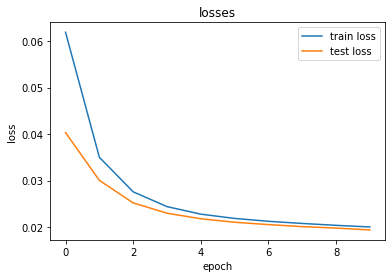

In [ ]:
plt.plot([entry['train loss'] for entry in history], label='train loss')
plt.plot([entry['test loss'] for entry in history], label='test loss')
plt.title('losses');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

### Save/load model

In [ ]:
torch.save(autoencoder, 'autoencoder_dense.pt')
# autoencoder = torch.load('autoencoder_dense.pt')

## Results visualization

For inference on small samples, we can use CPU - it allows to not care about 'cuda' stuff. If the models or images are large, better stay with GPU.

In [ ]:
autoencoder.to('cpu').eval();

In [ ]:
def reconstruct_image(img, model):
    with torch.no_grad():
        return model(img.unsqueeze(0))[0][0]

In [ ]:
img, target = mnist_test[0]
reconstruction = reconstruct_image(img, autoencoder)

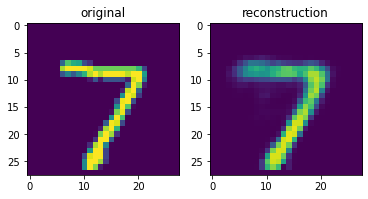

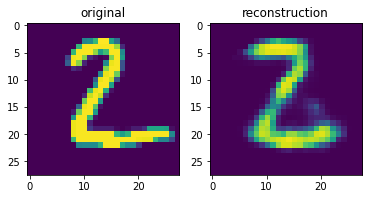

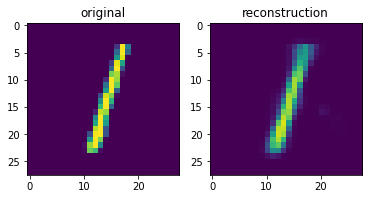

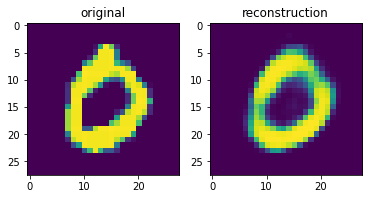

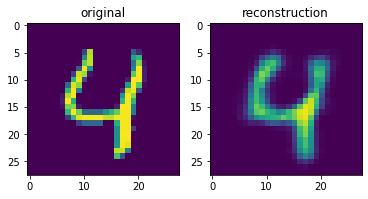

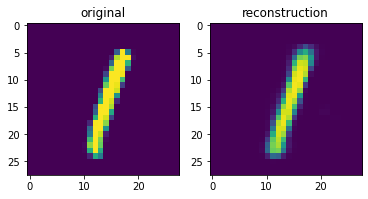

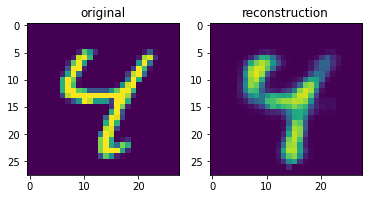

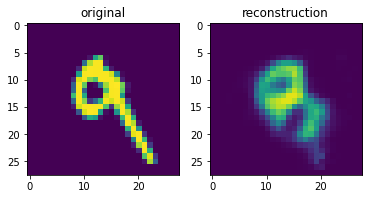

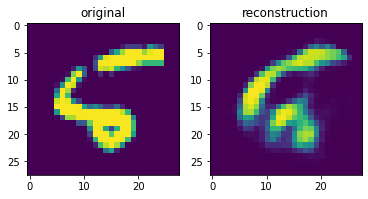

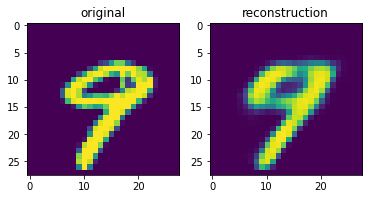

In [ ]:
for i in range(10):
    img, target = mnist_test[i]
    reconstruction = reconstruct_image(img, autoencoder)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title('original')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('reconstruction')

## Reconstruction errors and outliers
Autoencores may be used to detect outliers. Rare events tend to be poorly reconstructed by the model

In [ ]:
reconstruction_errors= []

# criterion gives us single loss for batch. Here the result is a vector of distances, one for each image
# equivalent to nn.functional.mse_loss(x, x_hat, reduction='none').sum(dim=(1,2,3))
def distance_function(x, x_hat):
    return torch.mean((x-x_hat)**2, dim=(1, 2, 3))

autoencoder.to(device);
for x, y in mnist_test_dataloader:
    x = x.to(device)
    x_hat, z = autoencoder(x.to(device))
    errors = distance_function(x, x_hat)
    reconstruction_errors.extend([el.item() for el in errors])

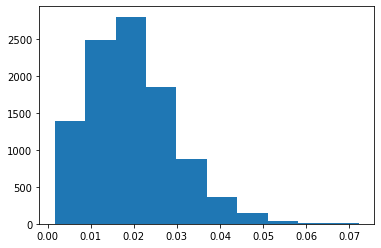

In [ ]:
plt.hist(reconstruction_errors);

In [ ]:
autoencoder.to('cpu');

Some of the worst cases..

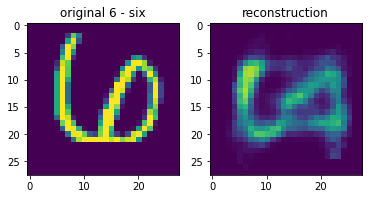

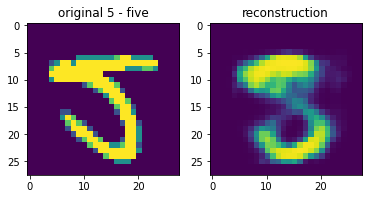

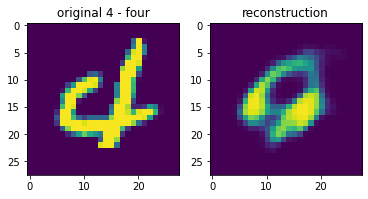

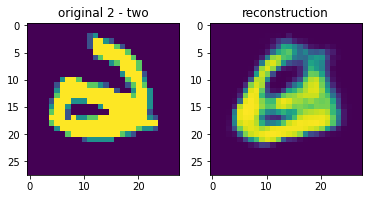

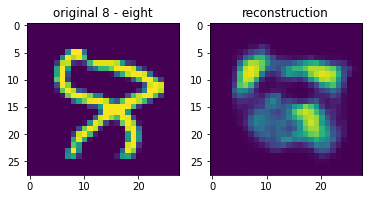

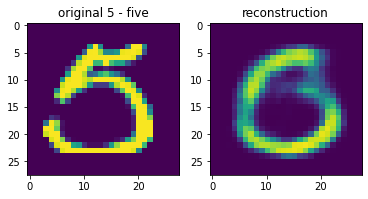

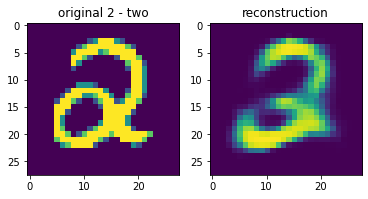

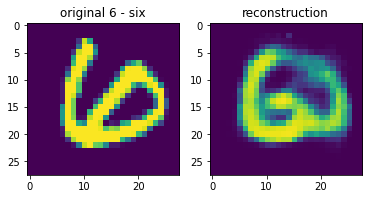

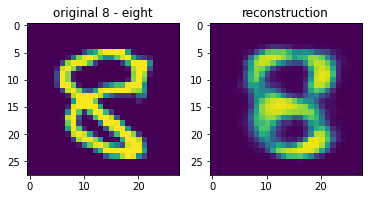

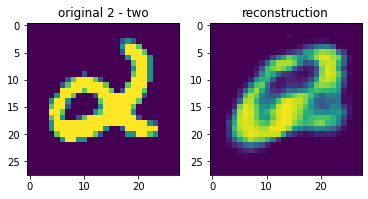

In [ ]:
for idx in np.argsort(reconstruction_errors)[-10:]:
    img, target = mnist_test[idx]
    reconstruction = reconstruct_image(img, autoencoder)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title(f'original {mnist_test.classes[target]}')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('reconstruction')

In [ ]:
labels = mnist_test.targets.numpy() #np.array([x[1] for x in mnist_test])

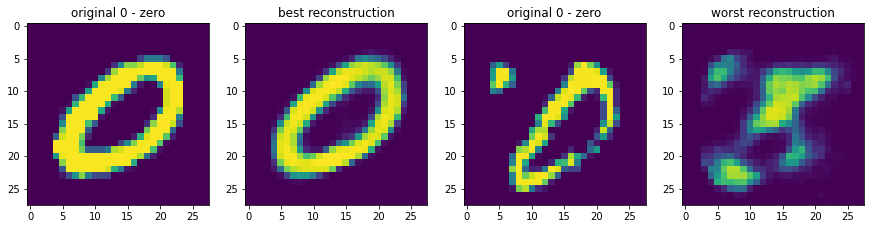

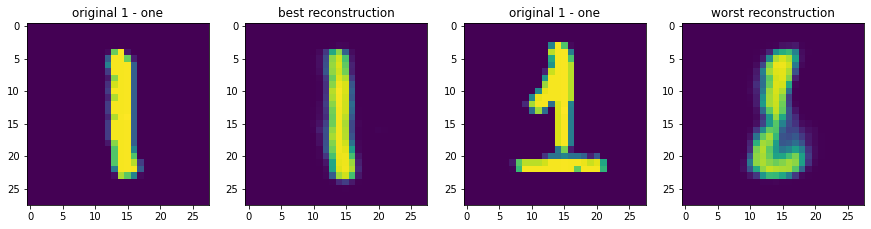

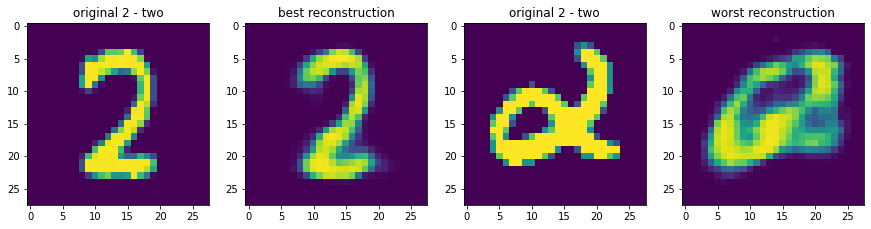

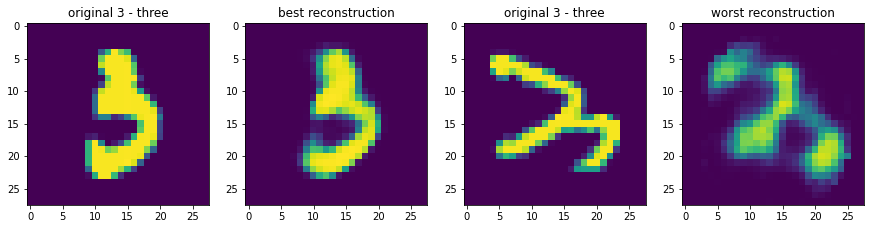

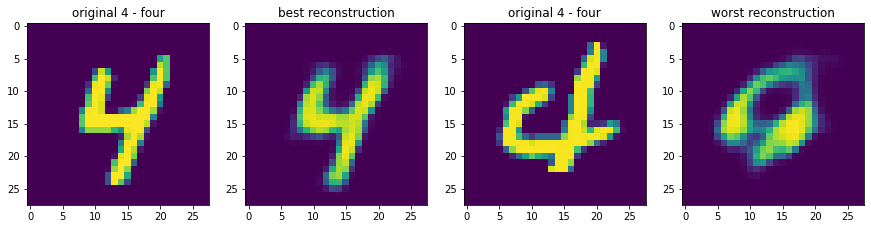

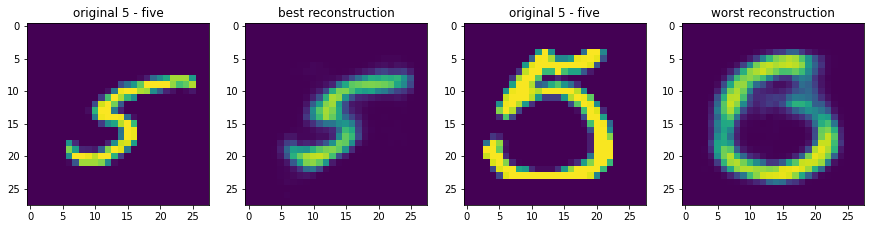

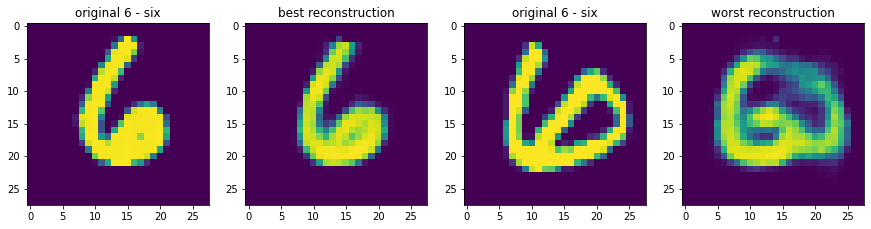

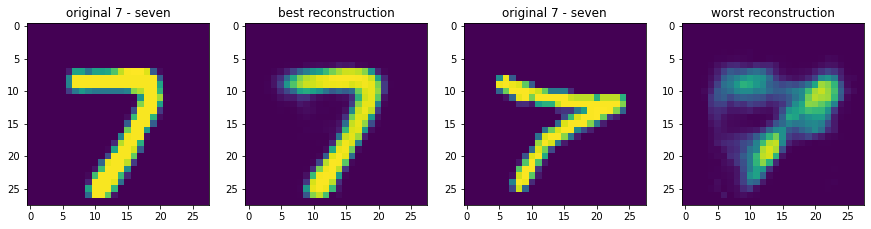

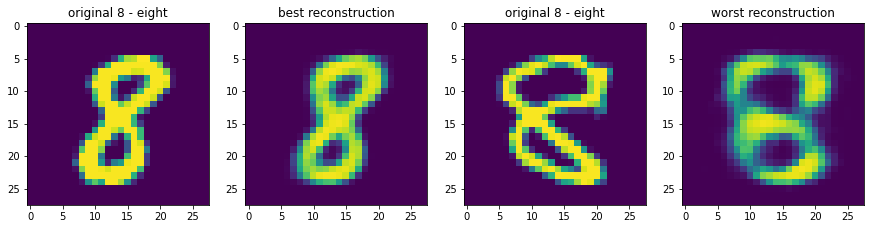

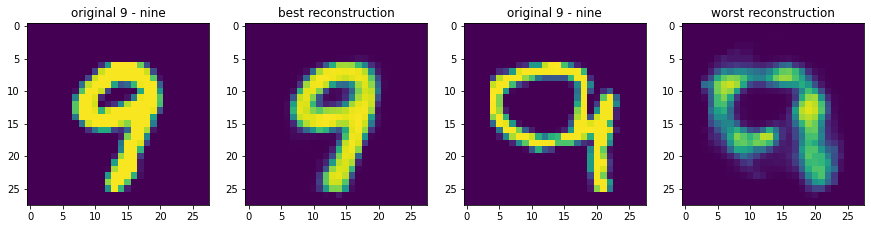

In [ ]:
reconstruction_errors = np.array(reconstruction_errors)
for digit in range(10):
    #get indices of the best and the worst reconstruction
    digit_indices = np.where(labels==digit)[0]
    idx_best = digit_indices[np.argmin(reconstruction_errors[digit_indices])]
    idx_worst = digit_indices[np.argmax(reconstruction_errors[digit_indices])]
    
    #create empty figure
    fig, axs = plt.subplots(ncols=4, figsize=(15, 6))
    
    img, target = mnist_test[idx_best]
    reconstruction = reconstruct_image(img, autoencoder)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title(f'original {mnist_test.classes[target]}')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('best reconstruction')
    
    img, target = mnist_test[idx_worst]
    reconstruction = reconstruct_image(img, autoencoder)
    axs[2].imshow(img[0], vmin=0, vmax=1)
    axs[2].set_title(f'original {mnist_test.classes[target]}')
    axs[3].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[3].set_title('worst reconstruction')

## Task: Anomaly detection

Autoencoders are often used in anomaly detection. In such application, the model is train on 'normal' dataset, learning to  compressed representations typical objects. When feeding with untypical sample, the autoencoder is expected to reconstruct object much worse, therefore the reconstrution error should be much larger. 

Now we will try to distinguish letters from digits. For the letters sample we will use EMNIST is dataset (similar to MNIST, but apart from digits it contains letters). We intend to compare reconstruction errors on digits and letters.

In [ ]:
from torchvision.datasets import EMNIST

In [ ]:
emnist_test = EMNIST(DATASETS_PATH, split='letters', train=False, download=True, transform=transforms.ToTensor());
print(emnist_test.classes)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Let's look at some letter examples:

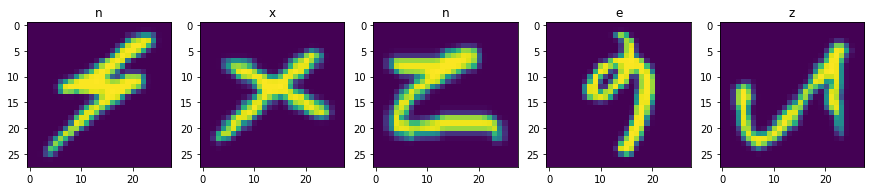

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(15,5))
for i, idx in enumerate(np.random.choice(np.arange(len(emnist_test)), 5)):
    img, target = emnist_test[idx]
    axs[i].imshow(img[0], vmin=0, vmax=1)
    axs[i].set_title(emnist_test.classes[target]);

As you, that the letters are rotated and mirrored. For out purpose it doesn't matter. If you care, use `img[0].T` for displaying or change dataset transform to `transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda img: img.transpose(1, 2))])`

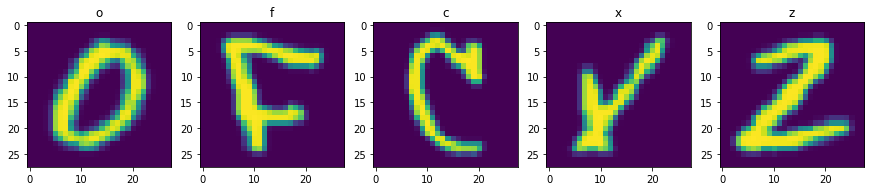

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(15,5))
for i, idx in enumerate(np.random.choice(np.arange(len(emnist_test)), 5)):
    img, target = emnist_test[idx]
    axs[i].imshow(img[0].T, vmin=0, vmax=1)
    axs[i].set_title(emnist_test.classes[target]);

In [ ]:
emnist_test = EMNIST(DATASETS_PATH, split='letters', train=False, download=True, 
                     transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda img: img.transpose(1, 2))])
                     );

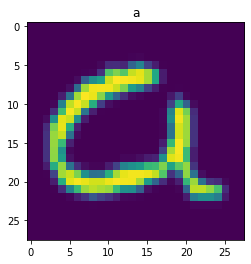

In [ ]:
img, target = emnist_test[2]
plt.imshow(img[0], vmin=0, vmax=1)
plt.title(emnist_test.classes[target]);

#### Task 3.1: calculate reconstruction error
Compute reconstruction errors for 1000 digits and 1000 letters.

In [ ]:
# generate dataset indices for digits and letters
digit_indices = np.random.choice(np.arange(len(mnist_test)), 1000)
letter_indices = np.random.choice(np.arange(len(emnist_test)), 1000)

In [ ]:
# set autoencoder to eval mode and set the device
autoencoder = autoencoder.eval().to(device)

Tip: rember to use torch.no_grad() and set the same device for model and data

In [ ]:
def calc_reconstruction_error(x, model):
    # your code here
    reconstruction_error = ...
    return reconstruction_error

In [ ]:
digits_reconstruction_errors= []
for idx in digit_indices:
    # your code here
    reconstruction_error = ...
    digits_reconstruction_errors.append(reconstruction_error)    

In [ ]:
letters_reconstruction_errors= []
for idx in letter_indices:
   # your code here
    reconstruction_error = ...
    letters_reconstruction_errors.append(reconstruction_error)  

Visualize the results:

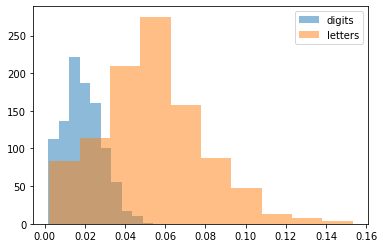

In [ ]:
plt.hist(digits_reconstruction_errors, alpha=0.5, label='digits');
plt.hist(letters_reconstruction_errors, alpha=0.5, label='letters');
plt.legend();

Short analysis of result

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_auc_score

In [ ]:
df = pd.DataFrame([{'class': 0, 'error': x} for x in digits_reconstruction_errors] + [{'class': 1, 'error': x} for x in letters_reconstruction_errors])
df.sample(10)

,class,error
122,0,0.026259
1801,1,0.053173
1396,1,0.053166
183,0,0.034600
999,0,0.003993
1717,1,0.075283
1163,1,0.093202
1043,1,0.028164
1374,1,0.041424
1851,1,0.071952


In [ ]:
precision, recall, thresholds = precision_recall_curve(df['class'], df['error'])
rocauc = roc_auc_score(df['class'], df['error'])

Text(0.5, 1.0, 'Area under curve: 0.897')

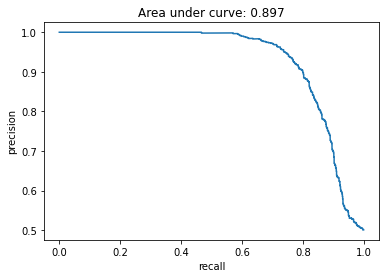

In [ ]:
plt.plot(recall, precision)
plt.xlabel('recall');
plt.ylabel('precision');
plt.title(f'Area under curve: {rocauc:0.3f}')

# Working with latent space


In [ ]:
@torch.no_grad()
def encode_image(img, model, device='cpu'):
  x_hat, z = model(img.unsqueeze(0).to(device))
  return z[0].to('cpu') # "[0]" beacuse 1st item of batch

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
N_prototypes = 20

In [ ]:
classes_indices = {}
for label in np.arange(len(mnist_train.classes)):
  classes_indices[label] = np.random.choice(np.where(mnist_train.targets==label)[0], size=N_prototypes, replace=False)

prepare training data

In [ ]:
X_train = []
y_train = []
for label, class_indices in classes_indices.items():
  for idx in class_indices:
    img, _ = mnist_train[idx]
    X_train.append(encode_image(img, autoencoder, device).numpy())
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_test = []
y_test = []
for idx in range(len(mnist_test)):
  img, label = mnist_test[idx]
  X_test.append(encode_image(img, autoencoder, device).numpy())
  y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
knn_cls = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [ ]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [ ]:
y_pred = knn_cls.predict(X_test)

Accuracy:

In [ ]:
np.mean(y_pred == y_test)

0.769

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

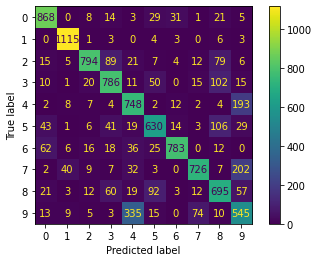

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Visualize latent space

In [ ]:
representations_digits = []
labels_digits = []

with torch.no_grad():
  for idx in digit_indices:
    img, label = mnist_test[idx]
    x = img.unsqueeze(0).to(device)
    x_hat, z = autoencoder(x)
    representations_digits.append(z[0].cpu().numpy())
    labels_digits.append(label)

representations_digits = np.array(representations_digits)
labels_digits = np.array(labels_digits)

In [ ]:
representations_letters = []
labels_letters = []

with torch.no_grad():
  for idx in letter_indices:
    img, label = emnist_test[idx]
    x = img.unsqueeze(0).to(device)
    x_hat, z = autoencoder(x)
    representations_letters.append(z[0].cpu().numpy())
    labels_letters.append(label)

representations_letters = np.array(representations_letters)
labels_letters = np.array(labels_letters)

In [ ]:
from sklearn.manifold import TSNE

"t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results"

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

You may try also [UMAP](https://umap-learn.readthedocs.io/en/latest/), which is faster.

Both often require parameter tuning to obtain nice visualizations.

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(np.concatenate((representations_digits, representations_letters)))
digits_embedded = X_embedded[:len(representations_digits)]
letters_embedded = X_embedded[len(representations_digits):]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


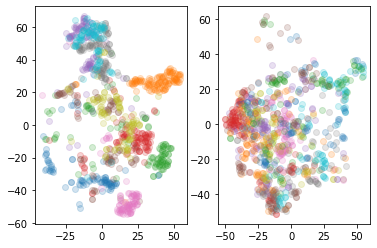

In [ ]:
fig, axs = plt.subplots(ncols=2)
for i, label in enumerate(sorted(set(labels_digits))):
    X_cat = digits_embedded[labels_digits==i]
    axs[0].scatter(X_cat[:,0], X_cat[:,1], label=mnist_test.classes[label], c=f'C{i}', alpha=0.2)
for i, label in enumerate(sorted(set(labels_letters))):
    X_cat = letters_embedded[labels_letters==i]
    axs[1].scatter(X_cat[:,0], X_cat[:,1], label=emnist_test.classes[label], c=f'C{i}', alpha=0.2)
# axs[0].scatter(X_embedded[:len(representations_digits), 0], X_embedded[:len(representations_digits), 1], alpha=0.1. )
# axs[1].scatter(X_embedded[len(representations_digits):, 0], X_embedded[len(representations_digits):, 1], alpha=0.1)

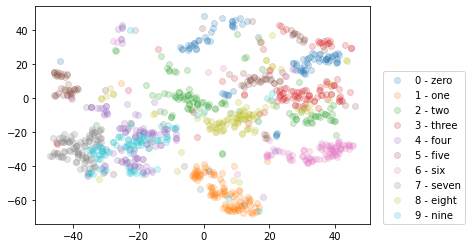

In [ ]:
for i, label in enumerate(sorted(set(labels_digits))):
    X_cat = digits_embedded[labels_digits==i]
    plt.scatter(X_cat[:,0], X_cat[:,1], label=mnist_test.classes[label], c=f'C{i}', alpha=0.2)
plt.legend(loc=(1.04,0))

In [ ]:
# import more colors
from matplotlib.colors import CSS4_COLORS
colors = list(CSS4_COLORS.keys())

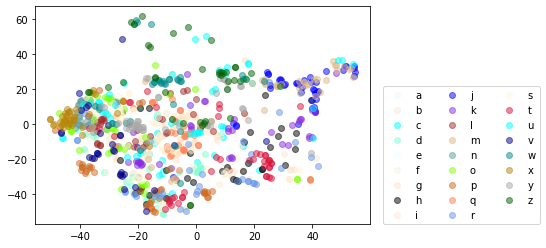

In [ ]:
for i, label in enumerate(sorted(set(labels_letters))):
    X_cat = letters_embedded[labels_letters==i]
    plt.scatter(X_cat[:,0], X_cat[:,1], label=emnist_test.classes[label], c=colors[i], alpha=0.5)
plt.legend(ncol=3, loc=(1.04,0))

# Different architectures

Try it!

In [ ]:
class ConvAutoencoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10 # here and bellow numbers correspods to dimensions: b (batch size), channels, height, width
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    
    @torch.no_grad()
    def encode_image(self, x):
        return self.encoder(x.unsqueeze(0))[0].view(1,-1)
        

In [ ]:
class ConvAutoencoder2(nn.Module):
    """from https://github.com/syorami/Autoencoders-Variants/blob/master/conv_autoencoder.py"""
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    
    @torch.no_grad()
    def encode_image(self, x):
        return self.encoder(x.unsqueeze(0))[0].view(1,-1)

In [ ]:
"""from https://github.com/eifuentes/swae-pytorch/blob/master/swae/models/mnist.py"""

class MNISTEncoder(nn.Module):
    """ MNIST Encoder from Original Paper's Keras based Implementation.
        Args:
            init_num_filters (int): initial number of filters from encoder image channels
            lrelu_slope (float): positive number indicating LeakyReLU negative slope
            inter_fc_dim (int): intermediate fully connected dimensionality prior to embedding layer
            embedding_dim (int): embedding dimensionality
    """
    def __init__(self, init_num_filters=16, lrelu_slope=0.2, inter_fc_dim=128, embedding_dim=2):
        super(MNISTEncoder, self).__init__()

        self.init_num_filters_ = init_num_filters
        self.lrelu_slope_ = lrelu_slope
        self.inter_fc_dim_ = inter_fc_dim
        self.embedding_dim_ = embedding_dim

        self.features = nn.Sequential(
            nn.Conv2d(1, self.init_num_filters_ * 1, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 1, self.init_num_filters_ * 1, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.AvgPool2d(kernel_size=2, padding=0),
            nn.Conv2d(self.init_num_filters_ * 1, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 2, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.AvgPool2d(kernel_size=2, padding=0),
            nn.Conv2d(self.init_num_filters_ * 2, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.AvgPool2d(kernel_size=2, padding=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(self.init_num_filters_ * 4 * 4 * 4, self.inter_fc_dim_),
            nn.ReLU(inplace=True),
            nn.Linear(self.inter_fc_dim_, self.embedding_dim_)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.init_num_filters_ * 4 * 4 * 4)
        x = self.fc(x)
        return x


class MNISTDecoder(nn.Module):
    """ MNIST Decoder from Original Paper's Keras based Implementation.
        Args:
            init_num_filters (int): initial number of filters from encoder image channels
            lrelu_slope (float): positive number indicating LeakyReLU negative slope
            inter_fc_dim (int): intermediate fully connected dimensionality prior to embedding layer
            embedding_dim (int): embedding dimensionality
    """
    def __init__(self, init_num_filters=16, lrelu_slope=0.2, inter_fc_dim=128, embedding_dim=2):
        super(MNISTDecoder, self).__init__()

        self.init_num_filters_ = init_num_filters
        self.lrelu_slope_ = lrelu_slope
        self.inter_fc_dim_ = inter_fc_dim
        self.embedding_dim_ = embedding_dim

        self.fc = nn.Sequential(
            nn.Linear(self.embedding_dim_, self.inter_fc_dim_),
            nn.Linear(self.inter_fc_dim_, self.init_num_filters_ * 4 * 4 * 4),
            nn.ReLU(inplace=True)
        )

        self.features = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=0),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 2, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 2, 1, kernel_size=3, padding=1)
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 4 * self.init_num_filters_, 4, 4)
        z = self.features(z)
        return torch.sigmoid(z)


class MNISTAutoencoder(nn.Module):
    """ MNIST Autoencoder from Original Paper's Keras based Implementation.
        Args:
            init_num_filters (int): initial number of filters from encoder image channels
            lrelu_slope (float): positive number indicating LeakyReLU negative slope
            inter_fc_dim (int): intermediate fully connected dimensionality prior to embedding layer
            embedding_dim (int): embedding dimensionality
    """
    def __init__(self, init_num_filters=16, lrelu_slope=0.2, inter_fc_dim=128, embedding_dim=2):
        super(MNISTAutoencoder, self).__init__()

        self.init_num_filters_ = init_num_filters
        self.lrelu_slope_ = lrelu_slope
        self.inter_fc_dim_ = inter_fc_dim
        self.embedding_dim_ = embedding_dim

        self.encoder = MNISTEncoder(init_num_filters, lrelu_slope, inter_fc_dim, embedding_dim)
        self.decoder = MNISTDecoder(init_num_filters, lrelu_slope, inter_fc_dim, embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

In [ ]:
"""from https://github.com/syorami/Autoencoders-Variants/blob/master/simple_autoencoder.py"""
class FCAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.reshape(input_shape[0], -1)
        z = self.encoder(x)
        x_hat = self.decoder(z) 
        return x_hat.reshape(input_shape), z

# Solutions

#### Task 1.1: write encoder class with a single hidden layer

In [ ]:
class Encoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            )

    def forward(self, x):
        x = self.net(x)
        return x

#### Task 1.2: write autoencoder class

In [ ]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()

        self.encoder = Encoder_1hl(hidden_dim, latent_dim)
        self.decoder = Decoder_1hl(hidden_dim, latent_dim)
            
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z) 
        return x_hat, z

#### Task 1.2a: add input reshaping:

In [ ]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()

        self.encoder = Encoder_1hl(hidden_dim, latent_dim)
        self.decoder = Decoder_1hl(hidden_dim, latent_dim)
            
    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.reshape(input_shape[0], -1)
        z = self.encoder(x)
        x_hat = self.decoder(z) 
        return x_hat.reshape(input_shape), z

#### Task 2.1: training loop

In [ ]:
num_epochs = 2

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(x)
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    print(f'epoch {i_epoch}, loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})
        

#### Task 2.2: evaluation function

In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion):
    losses = []
    model = model.eval()
    for batch in dataloader:  
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(x)
        loss = criterion(x, x_hat)
        losses.append(loss.item())
    final_loss = np.mean(losses)
    return final_loss

#### Task 3.1: calculate reconstruction error

In [ ]:
criterion = nn.MSELoss()
def calc_reconstruction_error(x, model):
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        x_hat, z = model(x)
        reconstruction_error = criterion(x, x_hat).item()
    return reconstruction_error

# #you can also use numpy
# @torch.no_grad()
# def calc_reconstruction_error(x, model):
#     x_hat = model(x.unsqueeze(0).to(device))[0]
#     reconstruction_error = np.mean((x_hat.cpu().numpy() - x.cpu().numpy())**2)
#     return reconstruction_error
   

In [ ]:
digits_reconstruction_errors= []
autoencoder = autoencoder.eval().to(device)
for idx in digit_indices:
    img, _ = mnist_test[idx]
    reconstruction_error = calc_reconstruction_error(img, autoencoder)
    digits_reconstruction_errors.append(reconstruction_error) 

In [ ]:
letters_reconstruction_errors= []
autoencoder = autoencoder.eval().to(device)
for idx in letter_indices:
    img, _ = emnist_test[idx]
    reconstruction_error = calc_reconstruction_error(img, autoencoder)
    letters_reconstruction_errors.append(reconstruction_error)    